Inspection of the entire CMC Human clinical data set and its subset that is relevant to our BSM study.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import synapseclient
import fwsel

In [2]:
syn = synapseclient.login()
wdir = '/big/results/bsm/2020-08-05-cmc-clinical'
cmc_clinical_syn = syn.get('syn2279441', downloadLocation=wdir, ifcollision='overwrite.local')
cmc_clinical = pd.read_csv(cmc_clinical_syn.path, index_col='Individual ID')

Welcome, Attila Jones!



In [3]:
samples = pd.read_csv('/big/results/bsm/2020-05-18-processed-samples/all_samples.csv')
individuals = list(set(samples['Individual ID']))
individuals.sort()
print(len(samples), 'samples from', len(individuals), 'individuals')

116 samples from 95 individuals


In [4]:
clin = cmc_clinical.loc[individuals, :]
clin.to_csv(wdir + '/all_samples_clinical.csv')
clin = clin.drop(columns='Reported Gender') # this is essentially the same as "Sex" 
clin

,Individual Notes,Institution,Brain ID,SCZ Pair,BP Pair,Changed (used Affy phenotype),Sex,Ethnicity,Race,Genotype Inferred Ancestry,...,Toxicology Screen: Moodstab,Toxicology Screen: Benzos,Toxicology Screen: Nicotine/Cotinine,Toxicology Screen: THC,Toxicology Screen: Cocaine,Toxicology Screen: Opiates,otherDiagnosis,otherMedicalDetail,mannerOfDeath,PMICertain
Individual ID,,,,,,,,,,,,,,,,,,,,,
CMC_MSSM_027,NaN,MSSM,NaN,NaN,NaN,NaN,XY,Caucasian,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CMC_MSSM_033,NaN,MSSM,NaN,NaN,NaN,NaN,XX,African-American,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CMC_MSSM_055,NaN,MSSM,NaN,NaN,NaN,NaN,XY,Caucasian,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CMC_MSSM_056,NaN,MSSM,NaN,NaN,NaN,NaN,XX,Caucasian,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CMC_MSSM_063,NaN,MSSM,NaN,NaN,NaN,NaN,XY,Caucasian,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMC_PITT_098,NaN,Pitt,NaN,Pitt 16,NaN,NaN,XY,Caucasian,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CMC_PITT_101,NaN,Pitt,NaN,Pitt 8,NaN,NaN,XY,Caucasian,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CMC_PITT_113,NaN,Pitt,NaN,NaN,NaN,NaN,XY,Caucasian,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
clin = clin.dropna(axis=1)
clin.columns

Index(['Institution', 'Sex', 'Ethnicity', 'ageOfDeath', 'PMI (in hours)', 'Dx',
       'Year of Autopsy', 'Benzodiazepines', 'Anticonvulsants', 'AntipsychTyp',
       'AntipsychAtyp', 'Antidepress', 'Lithium', 'Tobacco', 'Alcohol',
       'Illicitsub', 'causeOfDeath', 'Hyperten', 'DiabetesInsDep',
       'DiabetesNonInsDep'],
      dtype='object')

In [6]:
clin = clin.rename(columns={'PMI (in hours)': 'PMI', 'Year of Autopsy': 'YearOfAutopsy'})
clin.dtypes

Institution           object
Sex                   object
Ethnicity             object
ageOfDeath           float64
PMI                  float64
Dx                    object
YearOfAutopsy        float64
Benzodiazepines      float64
Anticonvulsants      float64
AntipsychTyp         float64
AntipsychAtyp        float64
Antidepress          float64
Lithium              float64
Tobacco              float64
Alcohol              float64
Illicitsub           float64
causeOfDeath         float64
Hyperten             float64
DiabetesInsDep       float64
DiabetesNonInsDep    float64
dtype: object

In [7]:
l = [clin.loc[:, :'Ethnicity'].astype('category'),
pd.DataFrame({'Dx': [np.int(y == 'SCZ') for y in clin['Dx']]}, index=clin.index),
clin.loc[:, 'Benzodiazepines':].astype('int').astype('category')]
clin = pd.concat(l, axis=1)

In [8]:
for col in clin.loc[:, 'Benzodiazepines':].columns:
    s = clin.groupby(col).size()
    if -1 in set(s.index):
        print(s.loc[-1], 'missing in', col)

31 missing in Tobacco
1 missing in Alcohol
1 missing in causeOfDeath
10 missing in Hyperten
10 missing in DiabetesInsDep
10 missing in DiabetesNonInsDep


In [9]:
clin = clin.drop(columns=['Tobacco', 'Hyperten', 'DiabetesInsDep', 'DiabetesNonInsDep'])

In [10]:
def replaceWithMode(col='Alcohol', clin=clin):
    '''Returns the mode i.e the most frequent category'''
    df = clin.groupby(col).size()
    d = dict(zip(list(df), df.index))
    mode = d[df.max()]
    s = clin[col]
    s = pd.Series([(lambda y: mode if y == -1 else y)(x) for x in s], index=clin.index, dtype='category')
    return(s)

clin['Alcohol'] = replaceWithMode(col='Alcohol')
clin['causeOfDeath'] = replaceWithMode(col='causeOfDeath')

In [11]:
#clin = clin.astype('category')
#clin = clin.astype({'ageOfDeath': np.float32, 'PMI': np.float32, 'YearOfAutopsy': np.float32})
#clin['Dx'] = [np.int(y == 'SCZ') for y in clin['Dx']] # Dx will be the response in regression
#clin

In [12]:
clin.columns

Index(['Institution', 'Sex', 'Ethnicity', 'Dx', 'Benzodiazepines',
       'Anticonvulsants', 'AntipsychTyp', 'AntipsychAtyp', 'Antidepress',
       'Lithium', 'Alcohol', 'Illicitsub', 'causeOfDeath'],
      dtype='object')

In [13]:
best = fwsel.forward_selected(clin, 'Dx')

In [14]:
best.model.formula

'Dx ~ AntipsychAtyp + Alcohol + AntipsychTyp + Ethnicity + Institution + Benzodiazepines + Sex + Antidepress + 1'

In [15]:
best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Dx   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     7.133
Date:                Thu, 06 Aug 2020   Prob (F-statistic):           4.97e-08
Time:                        21:53:33   Log-Likelihood:                -30.983
No. Observations:                  95   AIC:                             83.97
Df Residuals:                      84   BIC:                             112.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.6916      0.113      6.144      0.000       0.468       0.915
AntipsychAtyp[T.1]         0.4130      0.083      4.978      0.000       0.248       0.578
Alcohol[T.1]               0.3475      0.098      3.539      0.001       0.152       0.543
AntipsychTyp[T.1]          0.4128      0.103      3.989      0.000       0.207       0.619
Ethnicity[T.Caucasian]    -0.0579      0.105     -0.551      0.583      -0.267       0.151
Ethnicity[T.Hispanic]     -0.8072      0.276     -2.921      0.004      -1.357      -0.258
Institution[T.Pitt]       -0.1558      0.099     -1.578      0.118      -0.352       0.041
Benzodiazepines[T.1]      -0.1471      0.114     -1.285      0.202      -0.375       0.081
Sex[T.XXY]                 0.2823      0.379      0.744      0.459      -0.472       1.037
Sex[T.XY]                 -0.1647      0.086     -1.926      0.058      -0.335       0.005
Antidepress[T.1]          -0.1819      0.107     -1.707      0.091      -0.394       0.030
==============================================================================
Omnibus:                        4.862   Durbin-Watson:                   1.548
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                3.020
Skew:                          -0.245   Prob(JB):                        0.221
Kurtosis:                       2.277   Cond. No.                         16.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

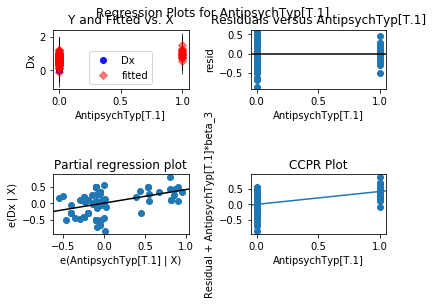

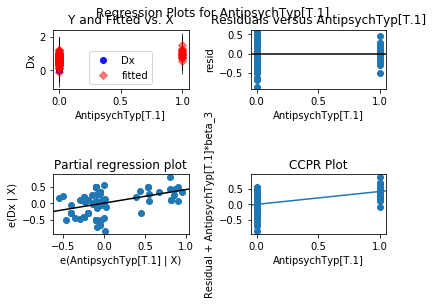

In [16]:
sm.graphics.plot_regress_exog(best, 'AntipsychTyp[T.1]')

In [17]:
%matplotlib tk
sm.graphics.plot_regress_exog(best, 'causeOfDeath[T.2.0]')

ValueError: 'causeOfDeath[T.2.0]' is not in list

In [ ]:
%connect_info